# Title I Allocations w/ DP ACS

In [1]:
from dp_policy.api import titlei_funding as funding, titlei_data as data, titlei_grid as test_params
from dp_policy.titlei.allocators import AbowdAllocator, SonnenbergAuthorizer
from dp_policy.titlei.utils import weighting
from dp_policy.titlei.mechanisms import Laplace, Gaussian, GroundTruth
from dp_policy.titlei.utils import get_saipe
from dp_policy.titlei.utils import get_sppe
from dp_policy.titlei.utils import get_allocation_data

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm.notebook import tqdm
import pandas as pd
import pickle
import geopandas as gpd
import seaborn as sns

saipe = get_saipe("../data/saipe19.xls")

plt.style.use('seaborn-deep')

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Allocation Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [3]:
sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

,state,ppe,abbrv
0,Alabama,9697,AL
1,Alaska,17726,AK
2,American Samoa,NaN,AS
3,Arizona,8296,AZ
4,Arkansas,10072,AR


Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [4]:
saipe = get_saipe("../data/saipe19.xls")
saipe.head()

State Postal Code  \
State FIPS Code District ID                     
1               190                        AL   
                5                          AL   
                30                         AL   
                60                         AL   
                90                         AL   

                                                            Name  \
State FIPS Code District ID                                        
1               190               Alabaster City School District   
                5               Albertville City School District   
                30           Alexander City City School District   
                60                Andalusia City School District   
                90                 Anniston City School District   

                             Estimated Total Population  \
State FIPS Code District ID                               
1               190                               34669   
                5                                 22051   
                30                                16920   
                60                                 8842   
                90                                22043   

                             Estimated Population 5-17  \
State FIPS Code District ID                              
1               190                               6710   
                5                                 4131   
                30                                2575   
                60                                1465   
                90                                3065   

                             Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder  \
State FIPS Code District ID                                                                                                          
1               190                                                        649                                                       
                5                                                          957                                                       
                30                                                         703                                                       
                60                                                         406                                                       
                90                                                        1057                                                       

                               cv  
State FIPS Code District ID        
1               190          0.23  
                5            0.23  
                30           0.28  
                60           0.35  
                90           0.23

In [5]:
# average school district student pop
saipe["Estimated Population 5-17"].mean()
saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].mean()

645.2559921116505

### Code

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

Finally, the main method for computing estimates, then grant amounts.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


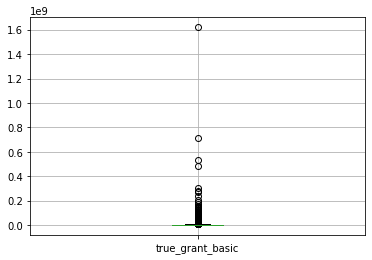

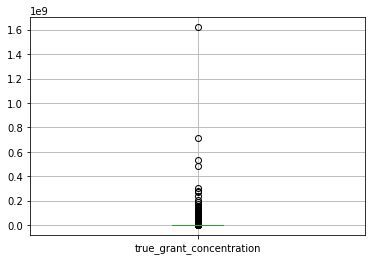

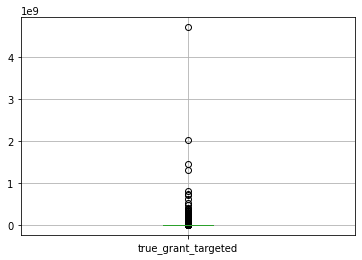

In [8]:
# Test with ground truth mechanism
grants = funding(SonnenbergAuthorizer, saipe, GroundTruth(), get_sppe("../data/sppe18.xlsx"))
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Hold harmless provision

In [10]:
test_params(saipe, Laplace, eps=[0.1, 1.0, 5.0], delta=[0.0], plot_results=False)
test_params(saipe, Laplace, eps=[0.1, 1.0, 5.0], delta=[0.0], plot_results=False, allocator_kwargs={'hold_harmless': True})

(0.1, 1.0, 5.0)
## dp
## basic grants ##
RMSE at eps=0.1: 141922.08243969138
RMSE prop eps=0.1: 0.03252667288204728
Total misalloc at eps=0.1: 1271667825.5949633
Total true alloc: 39875386755.81138
## concentration grants ##
RMSE at eps=0.1: 469650.15130545496
RMSE prop eps=0.1: 0.05143384384865762
Total misalloc at eps=0.1: 1409945191.6794446
Total true alloc: 29419819933.748734
## targeted grants ##
RMSE at eps=0.1: 296631.93266044906
RMSE prop eps=0.1: 0.03471564847907294
Total misalloc at eps=0.1: 2132287093.1739018
Total true alloc: 66725909503.0075
## total grants ##
RMSE at eps=0.1: 98422.55066981305
RMSE prop eps=0.1: 0.03752937021635681
Total misalloc at eps=0.1: 600433152.9954891
Total true alloc: 15999020221.60297
## dpest
## basic grants ##
RMSE at eps=0.1: 2583978.345028146
RMSE prop eps=0.1: 0.16975733445873994
Total misalloc at eps=0.1: 6730932126.65999
Total true alloc: 39875386755.81138
## concentration grants ##
RMSE at eps=0.1: 3043044.4498768565
RMSE prop eps=0.1: 0

State Postal Code  \
trial delta epsilon State FIPS Code District ID                     
0     0.0   0.1     1               190                        AL   
                                    5                          AL   
                                    30                         AL   
                                    60                         AL   
                                    90                         AL   
...                                                           ...   
            5.0     56              4260                       WY   
                                    6240                       WY   
                                    5820                       WY   
                                    4830                       WY   
                                    6090                       WY   

                                                                                Name  \
trial delta epsilon State FIPS Code District ID                                        
0     0.0   0.1     1               190               Alabaster City School District   
                                    5               Albertville City School District   
                                    30           Alexander City City School District   
                                    60                Andalusia City School District   
                                    90                 Anniston City School District   
...                                                                              ...   
            5.0     56              4260              Uinta County School District 6   
                                    6240           Washakie County School District 1   
                                    5820           Washakie County School District 2   
                                    4830             Weston County School District 1   
                                    6090             Weston County School District 7   

                                                 true_pop_total  \
trial delta epsilon State FIPS Code District ID                   
0     0.0   0.1     1               190                   34669   
                                    5                     22051   
                                    30                    16920   
                                    60                     8842   
                                    90                    22043   
...                                                         ...   
            5.0     56              4260                   3110   
                                    6240                   7135   
                                    5820                    670   
                                    4830                   5465   
                                    6090                   1462   

                                                 true_children_total  \
trial delta epsilon State FIPS Code District ID                        
0     0.0   0.1     1               190                         6710   
                                    5                           4131   
                                    30                          2575   
                                    60                          1465   
                                    90                          3065   
...                                                              ...   
            5.0     56              4260                         736   
                                    6240                        1295   
                                    5820                          90   
                                    4830                         816   
                                    6090                         249   

                                                 true_children_poverty    cv  \
trial delta epsilon State FIPS Code District ID                                
0     0.0   0.1     1               

## Laplace

### Results
First, using the full Sonnenberg authorization algo.

In [ ]:
results = test_params(saipe, Laplace, eps=[0.1, 1.0, 2.52, 10.0]+list(np.logspace(-3, 10, num=10)))
results.to_csv("../results/titlei_laplace.csv")

(0.1, 2.52)
## est
## basic grants ##
# districts: 1318200
Average true alloc: 3024987.616128914
Max true alloc: 1619696742.1992898
Max error: 639834379.8554883
RMSE at eps=0.1: 2993309.5803312953
Total misalloc at eps=0.1: 645302214456.5271
# small districts: 974400
Misalloc to large districts: 449841062877.1383
Misalloc to small districts: 195461151579.38974
Total true alloc: 3987538675580.6475
## concentration grants ##
# districts: 1318200
Average true alloc: 2231817.625075768
Max true alloc: 1619696742.1992898
Max error: 639834379.8554883
RMSE at eps=0.1: 3347193.2223127154
Total misalloc at eps=0.1: 761914784963.2728
# small districts: 974400
Misalloc to large districts: 530166254455.61053
Misalloc to small districts: 231748530507.62134
Total true alloc: 2941981993374.7285
## targeted grants ##
# districts: 1318200
Average true alloc: 5061895.729252566
Max true alloc: 4714287291.744015
Max error: 1919503139.5664635
RMSE at eps=0.1: 8710209.924873656
Total misalloc at eps=0.1: 137

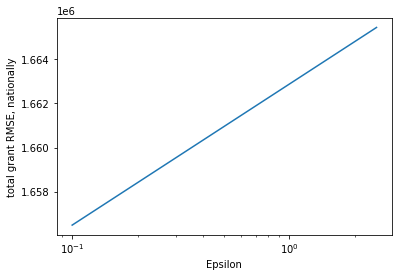

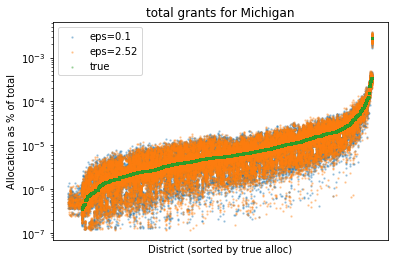

/Users/steed/dp-acs/dp_policy/api.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc[f"{prefix}_grant_{grant_type}"] /


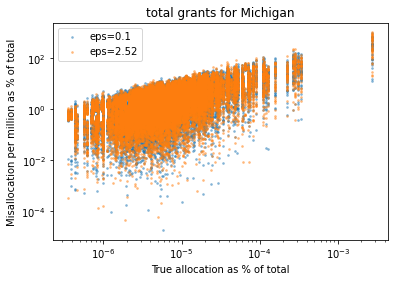

## dpest
## basic grants ##
# districts: 1318200
Average true alloc: 3024987.616128914
Max true alloc: 1619696742.1992898
Max error: 639423650.7464981
RMSE at eps=0.1: 2996581.947349624
Total misalloc at eps=0.1: 682601377455.2372
# small districts: 974400
Misalloc to large districts: 455236751080.8004
Misalloc to small districts: 227364626374.392
Total true alloc: 3987538675580.6475
## concentration grants ##
# districts: 1318200
Average true alloc: 2231817.625075768
Max true alloc: 1619696742.1992898
Max error: 639423650.7464981
RMSE at eps=0.1: 3351936.5961172744
Total misalloc at eps=0.1: 790881231032.0747
# small districts: 974400
Misalloc to large districts: 532971896389.61975
Misalloc to small districts: 257909334642.43353
Total true alloc: 2941981993374.7285
## targeted grants ##
# districts: 1318200
Average true alloc: 5061895.729252566
Max true alloc: 4714287291.744015
Max error: 1918270952.2394934
RMSE at eps=0.1: 8714863.665158696
Total misalloc at eps=0.1: 1439231821775.37

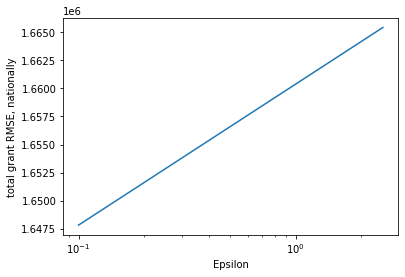

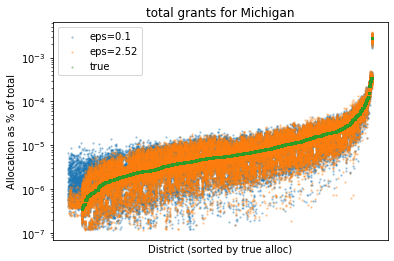

/Users/steed/dp-acs/dp_policy/api.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc[f"{prefix}_grant_{grant_type}"] /


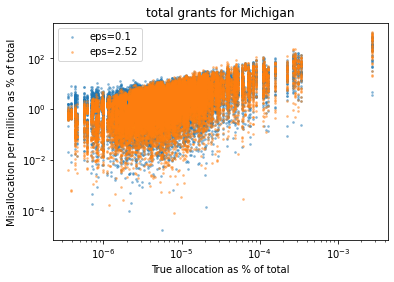

State Postal Code  \
trial delta epsilon State FIPS Code District ID                     
0     0.0   0.10    1               190                        AL   
                                    5                          AL   
                                    30                         AL   
                                    60                         AL   
                                    90                         AL   
...                                                           ...   
99    0.0   2.52    56              4260                       WY   
                                    6240                       WY   
                                    5820                       WY   
                                    4830                       WY   
                                    6090                       WY   

                                                                                Name  \
trial delta epsilon State FIPS Code District ID                                        
0     0.0   0.10    1               190               Alabaster City School District   
                                    5               Albertville City School District   
                                    30           Alexander City City School District   
                                    60                Andalusia City School District   
                                    90                 Anniston City School District   
...                                                                              ...   
99    0.0   2.52    56              4260              Uinta County School District 6   
                                    6240           Washakie County School District 1   
                                    5820           Washakie County School District 2   
                                    4830             Weston County School District 1   
                                    6090             Weston County School District 7   

                                                 true_pop_total  \
trial delta epsilon State FIPS Code District ID                   
0     0.0   0.10    1               190                   34669   
                                    5                     22051   
                                    30                    16920   
                                    60                     8842   
                                    90                    22043   
...                                                         ...   
99    0.0   2.52    56              4260                   3110   
                                    6240                   7135   
                                    5820                    670   
                                    4830                   5465   
                                    6090                   1462   

                                                 true_children_total  \
trial delta epsilon State FIPS Code District ID                        
0     0.0   0.10    1               190                         6710   
                                    5                           4131   
                                    30                          2575   
                                    60                          1465   
                                    90                          3065   
...                                                              ...   
99    0.0   2.52    56              4260                         736   
                                    6240                        1295   
                                    5820                          90   
                                    4830                         816   
                                    6090                         249   

                                                 true_children_poverty    cv  \
trial delta epsilon State FIPS Code District ID                                
0     0.0   0.10    1               

In [3]:
test_params(saipe, Laplace, eps=[0.1, 2.52], trials=100)

### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [12]:
grants = funding(AbowdAllocator, saipe, Laplace(2.52, 0, sensitivity=2.0), get_sppe("../data/sppe18.xlsx"))
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
Mean Sq. SPPE (2018): 26235395.69087739


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [13]:
# RMSE
error = grants.true_grant_total - grants.dp_grant_total
np.sqrt(np.mean(error**2))

5729.419640458363

In [14]:
print("Total misalloc at eps=2.52:", sum(abs(error)))

Total misalloc at eps=2.52: 52390267.7563839


In [15]:
grants = funding(AbowdAllocator, saipe, Laplace(4.74, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.dp_grant_total
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


3007.91078773349

In [17]:
grants = funding(AbowdAllocator, saipe, Laplace(0.1, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


2243651.00695352

## Gaussian (Advanced Composition, Approx. DP)

Add Gaussian noise ln(1/delta)/epsilon for better accuracy bound.

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:161: RuntimeWarning: overflow encountered in exp
  return phi(np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:161: RuntimeWarning: invalid value encountered in double_scalars
  return phi(np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:164: RuntimeWarning: overflow encountered in exp
  return phi(- np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:164: RuntimeWarning: invalid value encountered in double_scalars
  return phi(- np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta


(0.001, 0.027825594022071243, 0.774263682681127, 2.52, 21.54434690031882, 599.4842503189409, 16681.005372000593, 464158.8833612772, 12915496.650148828, 359381366.3804626, 10000000000.0)
## dp
## basic grants ##
RMSE at eps=2.52: 21399.19796113853
RMSE prop eps=2.52: 0.004691125745169814
Total misalloc at eps=2.52: 1857499037.3476112
Total true alloc: 398753867558.1087
## concentration grants ##
RMSE at eps=2.52: 100671.3283797714
RMSE prop eps=2.52: 0.006430091290918551
Total misalloc at eps=2.52: 1869504093.5586305
Total true alloc: 294198199337.48425
## targeted grants ##
RMSE at eps=2.52: 56692.94880990919
RMSE prop eps=2.52: 0.004404833980625078
Total misalloc at eps=2.52: 2903765215.9326797
Total true alloc: 667259095030.0739
## total grants ##
RMSE at eps=2.52: 15266.238953544133
RMSE prop eps=2.52: 0.00492429570329448
Total misalloc at eps=2.52: 787839065.3432262
Total true alloc: 159990202216.03195


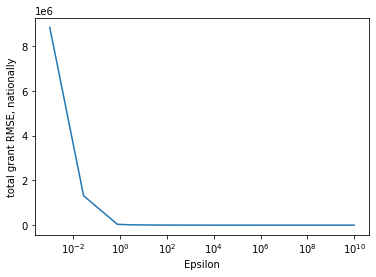

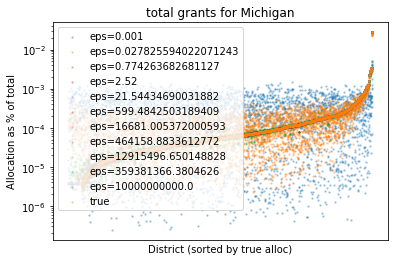

/Users/steed/dp-acs/dp_policy/api.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (


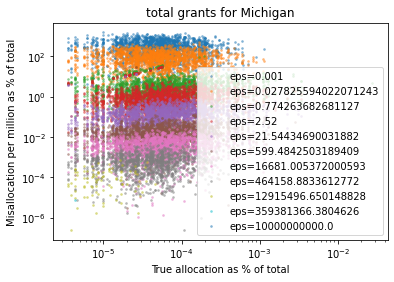

## dpest
## basic grants ##
RMSE at eps=2.52: 2730892.7708471036
RMSE prop eps=2.52: 0.1605220789051688
Total misalloc at eps=2.52: 64100091418.47471
Total true alloc: 398753867558.1087
## concentration grants ##
RMSE at eps=2.52: 3115379.4280794035
RMSE prop eps=2.52: 0.2559038715010952
Total misalloc at eps=2.52: 75780426908.8416
Total true alloc: 294198199337.48425
## targeted grants ##
RMSE at eps=2.52: 7905797.344754197
RMSE prop eps=2.52: 0.20086854941523397
Total misalloc at eps=2.52: 136090233079.47676
Total true alloc: 667259095030.0739
## total grants ##
RMSE at eps=2.52: 1550976.8201538778
RMSE prop eps=2.52: 0.20096552176913365
Total misalloc at eps=2.52: 32152514466.29373
Total true alloc: 159990202216.03195


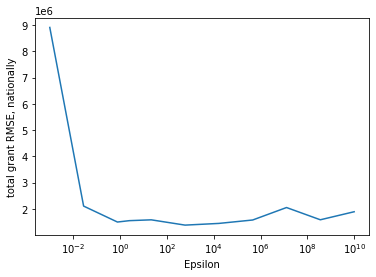

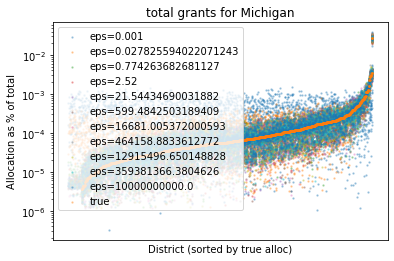

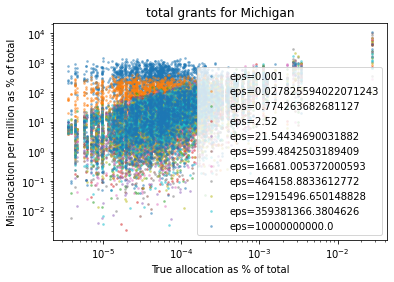

In [18]:
from dp_policy.titlei.mechanisms import Gaussian

# with delta = 0
results = test_params(
    saipe,
    Gaussian, 
    delta=list(np.linspace(1e-8, 1e-5, endpoint=False, num=10)),
    auth=False
)
results.to_csv("../results/titlei_gaussian.csv")

In [19]:
results = pd.read_csv("../results/titlei_gaussian.csv").set_index(['delta', 'epsilon', 'State FIPS Code', 'District ID'])
results.head()

trial State Postal Code  \
delta        epsilon State FIPS Code District ID                            
1.000000e-08 0.001   1               190              0                AL   
                                     5                0                AL   
                                     30               0                AL   
                                     60               0                AL   
                                     90               0                AL   

                                                                                 Name  \
delta        epsilon State FIPS Code District ID                                        
1.000000e-08 0.001   1               190               Alabaster City School District   
                                     5               Albertville City School District   
                                     30           Alexander City City School District   
                                     60                Andalusia City School District   
                                     90                 Anniston City School District   

                                                  true_pop_total  \
delta        epsilon State FIPS Code District ID                   
1.000000e-08 0.001   1               190                   34669   
                                     5                     22051   
                                     30                    16920   
                                     60                     8842   
                                     90                    22043   

                                                  true_children_total  \
delta        epsilon State FIPS Code District ID                        
1.000000e-08 0.001   1               190                         6710   
                                     5                           4131   
                                     30                          2575   
                                     60                          1465   
                                     90                          3065   

                                                  true_children_poverty    cv  \
delta        epsilon State FIPS Code District ID                                
1.000000e-08 0.001   1               190                            649  0.23   
                                     5                              957  0.23   
                                     30                             703  0.28   
                                     60                             406  0.35   
                                     90                            1057  0.23   

                                                  est_pop_total  \
delta        epsilon State FIPS Code District ID                  
1.000000e-08 0.001   1               190                  34669   
                                     5                    22051   
                                     30                   16920   
                                     60                    8842   
                                     90                   22043   

                                                  est_children_total  \
delta        epsilon State FIPS Code District ID                       
1.000000e-08 0.001   1               190                        6710   
                                     5                          4131   
                                     30                         2575   
                                     60                         1465   
                                     90                         3065   

                                                  est_children_poverty  ...  \
delta        epsilon State FIPS Code District ID                        ...   
1.000000e-08 0.001   1               190                    501.287375  ...   
                                     5                      920.205347  ...   
                                     3

Comparing dp


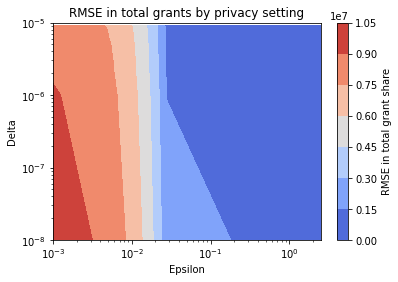

Comparing dpest


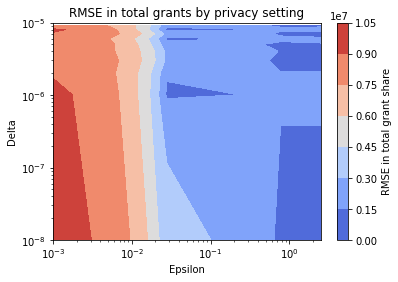

In [25]:
for prefix in ('dp', 'dpest'):
    print("Comparing", prefix)

    grant_type = 'total'

    eps = list(results.index.get_level_values("epsilon").unique())

    delts = list(results.index.get_level_values("delta").unique())
    mse = np.zeros((len(eps), len(delts)))
    for params, alloc in results.groupby(["epsilon", "delta"]):
        
        e, d = params
        error = alloc[f"true_grant_{grant_type}"] \
            - alloc[f"{prefix}_grant_{grant_type}"]
        mse[eps.index(e), delts.index(d)] = np.sqrt(sum(error**2)/alloc.shape[0])
        
    plt.contourf(eps, delts, mse.transpose(), cmap="coolwarm")
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yticks([1e-8, 1e-7, 1e-6, 1e-5])
    # ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    plt.xlim(None, 2.5)
    plt.xlabel("Epsilon")
    plt.ylabel("Delta")
    plt.title("RMSE in total grants by privacy setting")
    plt.colorbar(label="RMSE in total grant share")
    plt.show()

## Ground Truth Comparison
How close are our allocation estimates to the actual allocations from 2019? Note that we only have 2020's allocations, when really we need 2021's allocations, which will use the 2019 ACS data (see [here](https://www.nd.gov/dpi/sites/www/files/documents/Educational%20Equity%20%26%20Support/Title%20I/USED%20Census%202019%20Memo.pdf)). But historically the numbers are close.

Index(['LEAID', 'District', 'HistAlloc', 'state'], dtype='object')
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


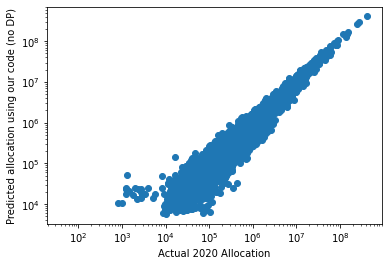

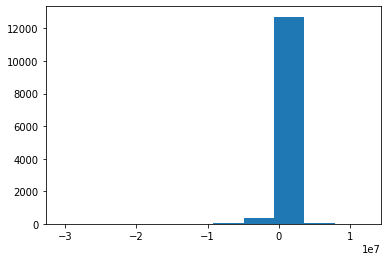

In [35]:
true_allocations = get_allocation_data("../data/titlei-allocations_20")
print(true_allocations.columns)
true_allocations["HistAlloc"].sum()

def compare_allocs(**kwargs):
    allocations = funding(
        SonnenbergAuthorizer, saipe, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"),
        allocator_kwargs=kwargs
    )
    allocs = allocations[
        ["true_grant_total", "true_grant_basic", "true_grant_concentration", "true_grant_targeted", "true_children_total", "true_children_eligible"]
    ].join(true_allocations[["HistAlloc", "District"]])
    allocs["error"] = allocs.HistAlloc - allocs.true_grant_total
    allocs.true_grant_total.sum()

    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.scatter(allocs.HistAlloc, allocs.true_grant_total)
    plt.xlabel("Actual 2020 Allocation")
    plt.ylabel("Predicted allocation using our code (no DP)")
    plt.show()
    plt.hist(allocs.error)
    plt.show()

compare_allocs()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


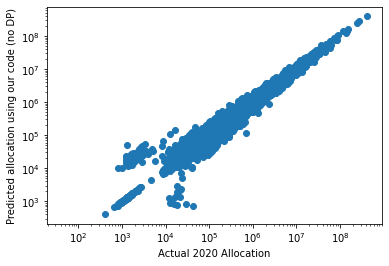

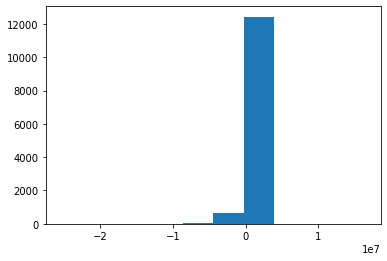

In [36]:
compare_allocs(hold_harmless=True)

Our method seems to be a little heteroskedastic. Variation could be due to 1) approximations in our funding algo; 2) differences in data.

In [37]:
# error per student
allocs["error_per_capita"] = allocs.error / allocs.true_children_total
np.mean(allocs.error_per_capita), np.sqrt(np.mean(allocs.error_per_capita**2))

(20.879231455964167, 148.36257841383988)

In [39]:
allocs.sort_values("error_per_capita").head(5)

,,true_grant_total,true_grant_basic,true_grant_concentration,true_grant_targeted,true_children_total,true_children_eligible,HistAlloc,District,error,error_per_capita
State FIPS Code,District ID,,,,,,,,,,
30,9210,52594.788882,116750.000000,116750.000000,2.136525e+05,55,25,1308.576975,Drummond High School District,-51286.211907,-932.476580
35,330,251061.187217,454411.236802,454411.236802,1.225660e+06,166,109,119891.947939,Carrizozo Municipal Schools,-131169.239279,-790.176140
41,3630,82010.314082,171043.200000,171043.200000,3.551522e+05,74,36,24329.785959,Harney County Union High School District 1J,-57680.528122,-779.466596
35,1,117562.343038,233458.984045,233458.984045,5.325783e+05,109,56,37999.407212,Vaughn Municipal Schools,-79562.935826,-729.935191
6,19920,47086.275678,95076.000000,95076.000000,2.101680e+05,31,19,25151.928704,Klamath River Union Elementary School District,-21934.346974,-707.559580


## Uncertainty

Adapted from `plot_sampling.ipynb`.

In [16]:
num_trials = 100
baseline = test_params(saipe, GroundTruth, eps=[0.01, 0.1, 2.52], delta=[0.0], trials=num_trials, print_results=False, plot_results=False)
laplace = test_params(saipe, Laplace, eps=[0.01, 0.1, 2.52], delta=[0.0], trials=num_trials, print_results=False, plot_results=False)
gaussian = test_params(saipe, Gaussian, eps=[0.01, 0.1, 2.52], delta=[1e-6], trials=num_trials, print_results=False, plot_results=False)

pickle.dump(baseline, open("../results/bootstrap/baseline.pkl", 'wb'))
pickle.dump(laplace, open("../results/bootstrap/laplace.pkl", 'wb'))
pickle.dump(gaussian, open("../results/bootstrap/gaussian.pkl", 'wb'))

In [2]:
baseline = pickle.load(open("../results/bootstrap/baseline.pkl", 'rb'))
laplace = pickle.load(open("../results/bootstrap/laplace.pkl", 'rb'))
gaussian = pickle.load(open("../results/bootstrap/gaussian.pkl", 'rb'))

In [3]:
epsilon = 0.1
num_bins = 10

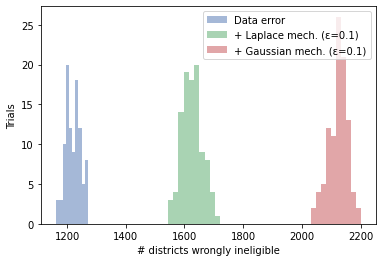

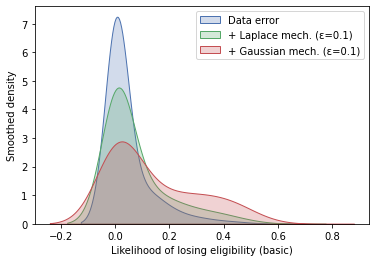

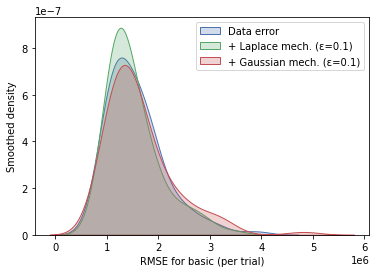

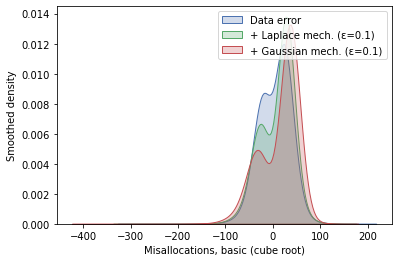

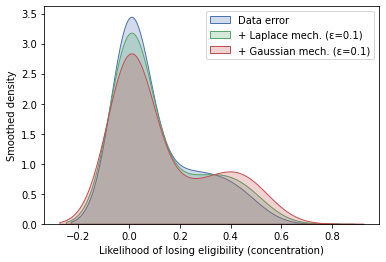

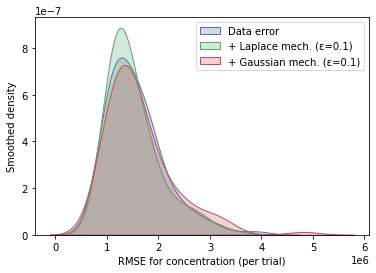

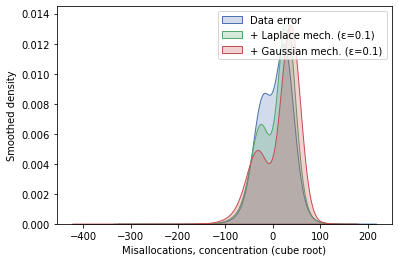

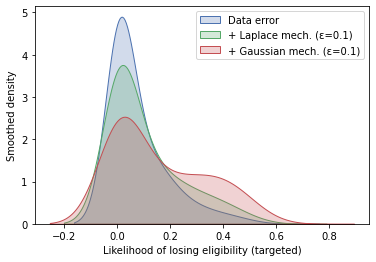

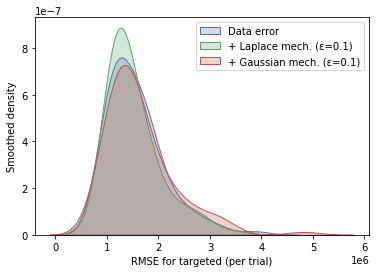

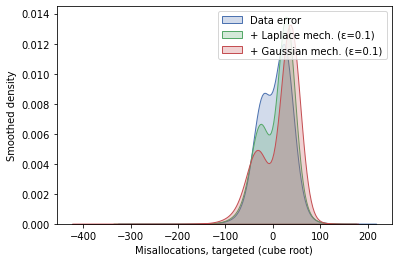

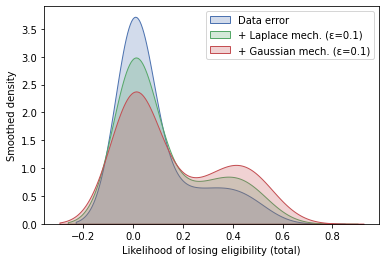

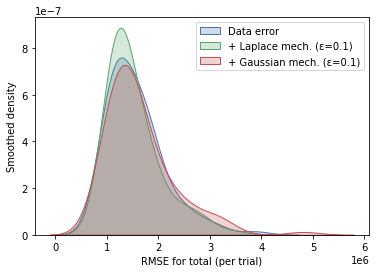

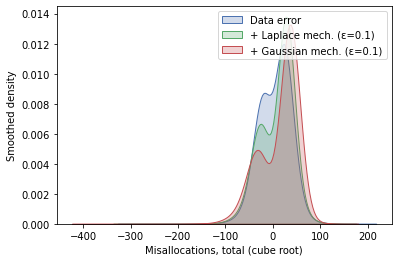

In [4]:
def plot_treatments(treatments, x_func, plot_method, plot_kwargs, filename, xlab=None, ylab="Smoothed density", grant="total"):
  for treatment, df_raw in treatments.items():
    df = df_raw.loc[(slice(None), slice(None), epsilon, slice(None), slice(None)), :].copy()
    df.loc[:, "misalloc"] = df[f"dpest_grant_{grant}"] - df[f"true_grant_{grant}"]
    df.loc[:, "misalloc_sq"] = np.power(df["misalloc"], 2)
    if grant == "total":
      df["lost_eligibility"] = \
          (df["dpest_eligible_basic"] & ~df["true_eligible_basic"]) |\
          (df["dpest_eligible_concentration"] & ~df["true_eligible_concentration"]) |\
          (df["dpest_eligible_targeted"] & ~df["true_eligible_targeted"])
    else:
        df["lost_eligibility"] = \
            ~df["dpest_eligible_{}".format(grant)] & df["true_eligible_{}".format(grant)]
    plot_kwargs['label'] = treatment
    plot_method(x_func(df), **plot_kwargs)

  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.legend(loc='upper right')
  plt.savefig(f"../plots/bootstrap/{filename}.png", dpi=100)
  plt.show()
  plt.close()

treatments = {
  "Data error": baseline,
  "+ Laplace mech. (ε={})".format(epsilon): laplace,
  "+ Gaussian mech. (ε={})".format(epsilon): gaussian,
}
plot_treatments(
  treatments,
  lambda df: df.groupby('trial')["lost_eligibility"].sum(),
  plt.hist,
  dict(bins=num_bins, alpha=0.5),
  "ineligible_hist",
  xlab="# districts wrongly ineligible",
  ylab="Trials"
)

for grant in ["basic", "concentration", "targeted", "total"]:
  plot_treatments(
    treatments,
    lambda df: df.groupby(['State FIPS Code', 'District ID'])["lost_eligibility"].mean(),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    f"likelihood_ineligible_{grant}",
    xlab=f"Likelihood of losing eligibility ({grant})",
    grant=grant
  )

  plot_treatments(
    treatments,
    lambda df: np.sqrt(df.groupby('trial')["misalloc_sq"].mean()),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    f"rmse_{grant}",
    xlab=f"RMSE for {grant} (per trial)"
  )

  plot_treatments(
    treatments,
    lambda df: \
      np.sign(df.groupby(['State FIPS Code', 'District ID'])["misalloc"].mean())*np.power(
        np.abs(df.groupby(['State FIPS Code', 'District ID'])["misalloc"].mean()), 1/3),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    f"misalloc_{grant}",
    xlab=f"Misallocations, {grant} (cube root)"
  )

## Discrimination

### Data
Using 2014-2018 ACS race data by school district from the NCES. See notes for more details.

Data for just the total child population

In [16]:
from dp_policy.titlei.utils import get_acs_data

demographics = get_acs_data(
    "../data/discrimination/CDP05.txt",
    "demo"
)
print(demographics.shape)
social = get_acs_data(
    "../data/discrimination/CDP02.txt",
    "social"
)
print(social.shape)
economic = get_acs_data(
    "../data/discrimination/CDP03.txt",
    "social"
)
print(economic.shape)
housing = get_acs_data(
    "../data/discrimination/CDP04.txt",
    "housing"
)
print(housing.shape)

(11721, 256)
(11720, 340)


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (183,184,185,186) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(11721, 202)


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (161,162,279,280,283,284,287,288,291,292,295,296,299,300,303,304,307,308,315,316,319,320) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(11721, 494)


In [17]:
acs = demographics.join(social, lsuffix="_demo", rsuffix="_social", how="inner")\
    .join(economic, rsuffix="_econ", how="inner")\
    .join(housing, rsuffix="_housing", how="inner")
print(acs.shape)
print(acs[acs['Total population (RACE) - est'].isna()].shape)
# print(list(c for c in acs.columns if "est" in c or "pct" in c))

(11720, 1292)
(0, 1292)


In [18]:
saipe = get_saipe("../data/saipe19.xls")
# saipe = saipe.join(acs, how="inner")

In [ ]:
from dp_policy.titlei.mechanisms import Gaussian

# run 100 trials for a signle eps, delta combo
eps = 0.1
f = '../results/discrimination_laplace_eps={}.pkl'.format(eps)
results = test_params(
    saipe,
    Laplace, 
    eps=[eps],
#     delta=[1e-6],
    trials=100
)
pickle.dump(results, open(f, 'wb'))

### Output

In [14]:
f = '../results/discrimination_laplace_eps=0.1.pkl'
# f = '../results/discrimination.pkl'

In [24]:
results = pickle.load(open(f, 'rb'))

print(results.shape)
variables = [
    'Total population (RACE) - est',
]
# add race variables
variables += [
    r for r in acs.columns 
    if r.endswith("(RACE) - pct") and "and" not in r and "races" not in r and not r.startswith("One race")
] + ["Two or more races (RACE) - pct"]
# add ethnicity variables
hisp = [
    r for r in acs.columns 
    if r.endswith("(HISPANIC OR LATINO AND RACE) - pct")
]
variables += hisp[1:6]
# add income variables
variables += [
    r for r in acs.columns 
    if r.startswith("Median household income (dollars) (")
]
# add rural/urban - need a 3rd data source
# add immigrant status
variables += [
    "Foreign born (PLACE OF BIRTH) - est",
    "Foreign born (PLACE OF BIRTH) - pct",
    "Not a U.S. citizen (U.S. CITIZENSHIP STATUS) - est",
    "Not a U.S. citizen (U.S. CITIZENSHIP STATUS) - pct"
]
# add language isolation
variables += [
    'Language other than English (LANGUAGE SPOKEN AT HOME) - est',
    'Language other than English (LANGUAGE SPOKEN AT HOME) - pct'
]
# add renters vs. homeowners (housing security)
variables += [
    'Renter-occupied (HOUSING TENURE) - est',
    'Renter-occupied (HOUSING TENURE) - pct',
    'Average household size of renter-occupied unit (HOUSING TENURE) - est'
]
print(variables)

# adding geographic area
geo = gpd.read_file("../data/shapefiles/school_districts_19/schooldistrict_sy1819_tl19.shp")
geo.STATEFP = geo.STATEFP.astype(int)
geo["District ID"] = np.where(geo.UNSDLEA.notna(), geo.UNSDLEA, np.where(geo.SCSDLEA.notna(), geo.SCSDLEA, geo.ELSDLEA))
geo["District ID"] = geo["District ID"].astype(int)
geo = geo.rename(columns={
    "STATEFP": "State FIPS Code"
}).set_index(["State FIPS Code", "District ID"])

grants = results.join(acs[variables], how="inner")
print(grants.shape)
grants = grants.join(geo["ALAND"])
print(grants.shape)
print(grants[grants["Total population (RACE) - est"].isna()].groupby(["State FIPS Code", "District ID"]).groups.keys())
grants.to_csv(f[:-4]+".csv")

(1318200, 48)
['Total population (RACE) - est', 'White (RACE) - pct', 'Black or African American (RACE) - pct', 'Cherokee tribal grouping (RACE) - pct', 'Chippewa tribal grouping (RACE) - pct', 'Navajo tribal grouping (RACE) - pct', 'Sioux tribal grouping (RACE) - pct', 'Asian (RACE) - pct', 'Asian Indian (RACE) - pct', 'Chinese (RACE) - pct', 'Filipino (RACE) - pct', 'Japanese (RACE) - pct', 'Korean (RACE) - pct', 'Vietnamese (RACE) - pct', 'Other Asian (RACE) - pct', 'Native Hawaiian (RACE) - pct', 'Guamanian or Chamorro (RACE) - pct', 'Samoan (RACE) - pct', 'Some other race (RACE) - pct', 'Two or more races (RACE) - pct', 'Mexican (HISPANIC OR LATINO AND RACE) - pct', 'Puerto Rican (HISPANIC OR LATINO AND RACE) - pct', 'Cuban (HISPANIC OR LATINO AND RACE) - pct', 'Other Hispanic or Latino (HISPANIC OR LATINO AND RACE) - pct', 'Not Hispanic or Latino (HISPANIC OR LATINO AND RACE) - pct', 'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - e

### Geography

In [12]:
print(geo.loc[1, 1])

ELSDLEA                                                    None
SCSDLEA                                                    None
UNSDLEA                                                   00001
GEOID                                                   0100001
NAME                                Fort Rucker School District
LSAD                                                         00
LOGRADE                                                      KG
HIGRADE                                                      12
MTFCC                                                     G5420
SDTYP                                                         B
FUNCSTAT                                                      E
ALAND                                               232947983.0
AWATER                                                2801707.0
INTPTLAT                                            +31.4097368
INTPTLON                                           -085.7458071
GEO_YEAR                                

<AxesSubplot:>

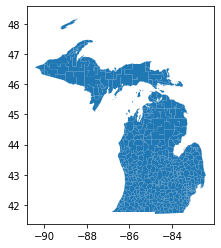

In [8]:
# michigan
geo.loc[26].plot()

In [30]:
results["error"] =  results.est_grant_total - results.true_grant_total
results["error_per_child"] =  results.error / results['true_children_total']
results["error_per_child_eligible"] =  results.error / results['true_children_eligible']
results["error_dp"] =  results.dpest_grant_total - results.true_grant_total
results["error_dp_per_child"] =  results.error_dp / results['true_children_total']
results["error_dp_per_child_eligible"] =  results.error_dp / results['true_children_eligible']
# geo.join()
results["percent_eligible"] = results["true_children_eligible"] / results["true_children_total"]
results["switched_eligibility"] = ~((results.est_eligible_targeted == results.true_eligible_targeted) & (results.est_eligible_basic == results.true_eligible_basic) &(results.est_eligible_concentration == results.true_eligible_concentration))
results["became_eligible"] = (results.est_eligible_targeted & ~results.true_eligible_targeted) | (results.est_eligible_basic & ~results.true_eligible_basic) | (results.est_eligible_concentration & ~results.true_eligible_concentration)
results["became_ineligible"] = (~results.est_eligible_targeted & results.true_eligible_targeted) | (~results.est_eligible_basic & results.true_eligible_basic) | (~results.est_eligible_concentration & results.true_eligible_concentration)
results["switched_eligibility_dp"] = ~((results.dpest_eligible_targeted == results.true_eligible_targeted) & (results.dpest_eligible_basic == results.true_eligible_basic) &(results.dpest_eligible_concentration == results.true_eligible_concentration))
results["became_eligible_dp"] = (results.dpest_eligible_targeted & ~results.true_eligible_targeted) | (results.dpest_eligible_basic & ~results.true_eligible_basic) | (results.dpest_eligible_concentration & ~results.true_eligible_concentration)
results["became_ineligible_dp"] = (~results.dpest_eligible_targeted & results.true_eligible_targeted) | (~results.dpest_eligible_basic & results.true_eligible_basic) | (~results.dpest_eligible_concentration & results.true_eligible_concentration)
results["dp_marginal"] = results["error_dp_per_child"] - results["error_per_child"]

joined = geo.join(
    results[[
        "error",
        "error_per_child",
        "error_per_child_eligible",
        "error_dp",
        "error_dp_per_child",
        "error_dp_per_child_eligible",
        "true_children_eligible",
        "true_pop_total",
        "percent_eligible",
        "true_grant_total",
        "switched_eligibility",
        "became_eligible",
        "became_ineligible",
        "switched_eligibility_dp",
        "became_eligible_dp",
        "became_ineligible_dp",
        "dp_marginal"
    ]].groupby(["State FIPS Code", "District ID", "epsilon", "delta"]).mean().reset_index(level=["epsilon", "delta"]),
    how="inner"
)
joined.loc[np.isinf(joined["error_per_child"]), "error_per_child"] = np.nan
joined.loc[np.isinf(joined["error_per_child_eligible"]), "error_per_child_eligible"] = np.nan
joined.loc[np.isinf(joined["error_dp_per_child"]), "error_dp_per_child"] = np.nan
joined.loc[np.isinf(joined["error_dp_per_child_eligible"]), "error_dp_per_child_eligible"] = np.nan

In [29]:
import matplotlib.colors as pltc

def cube(x):
    return np.sign(x)*np.power(np.abs(x), 1/3)

def heatmap(
    data, label=None, transform='cube', theme="RdBu", 
    y="error_dp_per_child", vcenter=0, file=None,
    figsize=(10,5), bar_location = 'bottom', min=None, max=None
):
    fig, ax = plt.subplots(1, figsize=figsize, dpi=300)
    
    if transform == 'cube':
        data.loc[:,y] = cube(data[y])
    if transform == 'log':
        data.loc[:,y] = np.where(data[y] == 0, 0, np.log(data[y]))
    
    # Create colorbar as a legend
    if min is None and max is None:
        min = data[y].min()
        max = data[y].max()

    if vcenter is not None and transform != 'log':
        norm = pltc.TwoSlopeNorm(vcenter=0, vmin=min, vmax=max)
    else:
        norm = pltc.Normalize(vmin=min, vmax=max)
    sm = plt.cm.ScalarMappable(cmap=theme, norm=norm)

    data.plot(column=y, cmap=theme, norm=norm, ax=ax, linewidth=0.05, edgecolor='0.2')
    cb = fig.colorbar(sm, location=bar_location, shrink=0.5, pad=0.05, aspect=30)
    cb.set_label(label)
    # if label is not None:
    #     plt.title(label)
    plt.axis('off')
    plt.tight_layout()
    if file is not None:
        plt.savefig(f"../plots/geo/{file}", dpi=300)
        plt.close()
    else:
        plt.show()
    
#     display(data[data[y].notna()].sort_values(y).tail(1))

In [31]:
dperr = cube(joined.loc[[
    f for f in joined.index.get_level_values("State FIPS Code").unique()
    if f not in [2, 15]
]]["error_dp_per_child"])
dpmin = dperr.min()
dpmax = dperr.max()
serr = cube(joined.loc[[
    f for f in joined.index.get_level_values("State FIPS Code").unique()
    if f not in [2, 15]
]]["error_per_child"])
smin = serr.min()
smax = serr.max()
ymin = smin if smin <= dpmin else dpmin
ymax = smax if smax >= dpmax else dpmax
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    label="Misallocation per child (cube root)",
    y="error_dp_per_child",
    file="misalloc_nation.png",
    figsize=(15,10),
    bar_location = 'right',
    # min=ymin,
    # max=ymax
)
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    y="error_per_child",
    label="Misallocation per child (cube root)",
    file="misalloc_nation_sampling.png",
    figsize=(15,10),
    bar_location = 'right',
    min=ymin,
    max=ymax
)
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    y="dp_marginal",
    label="Misallocation per child (cube root)",
    file="misalloc_nation_marginal.png",
    figsize=(15,10),
    bar_location = 'right'
)

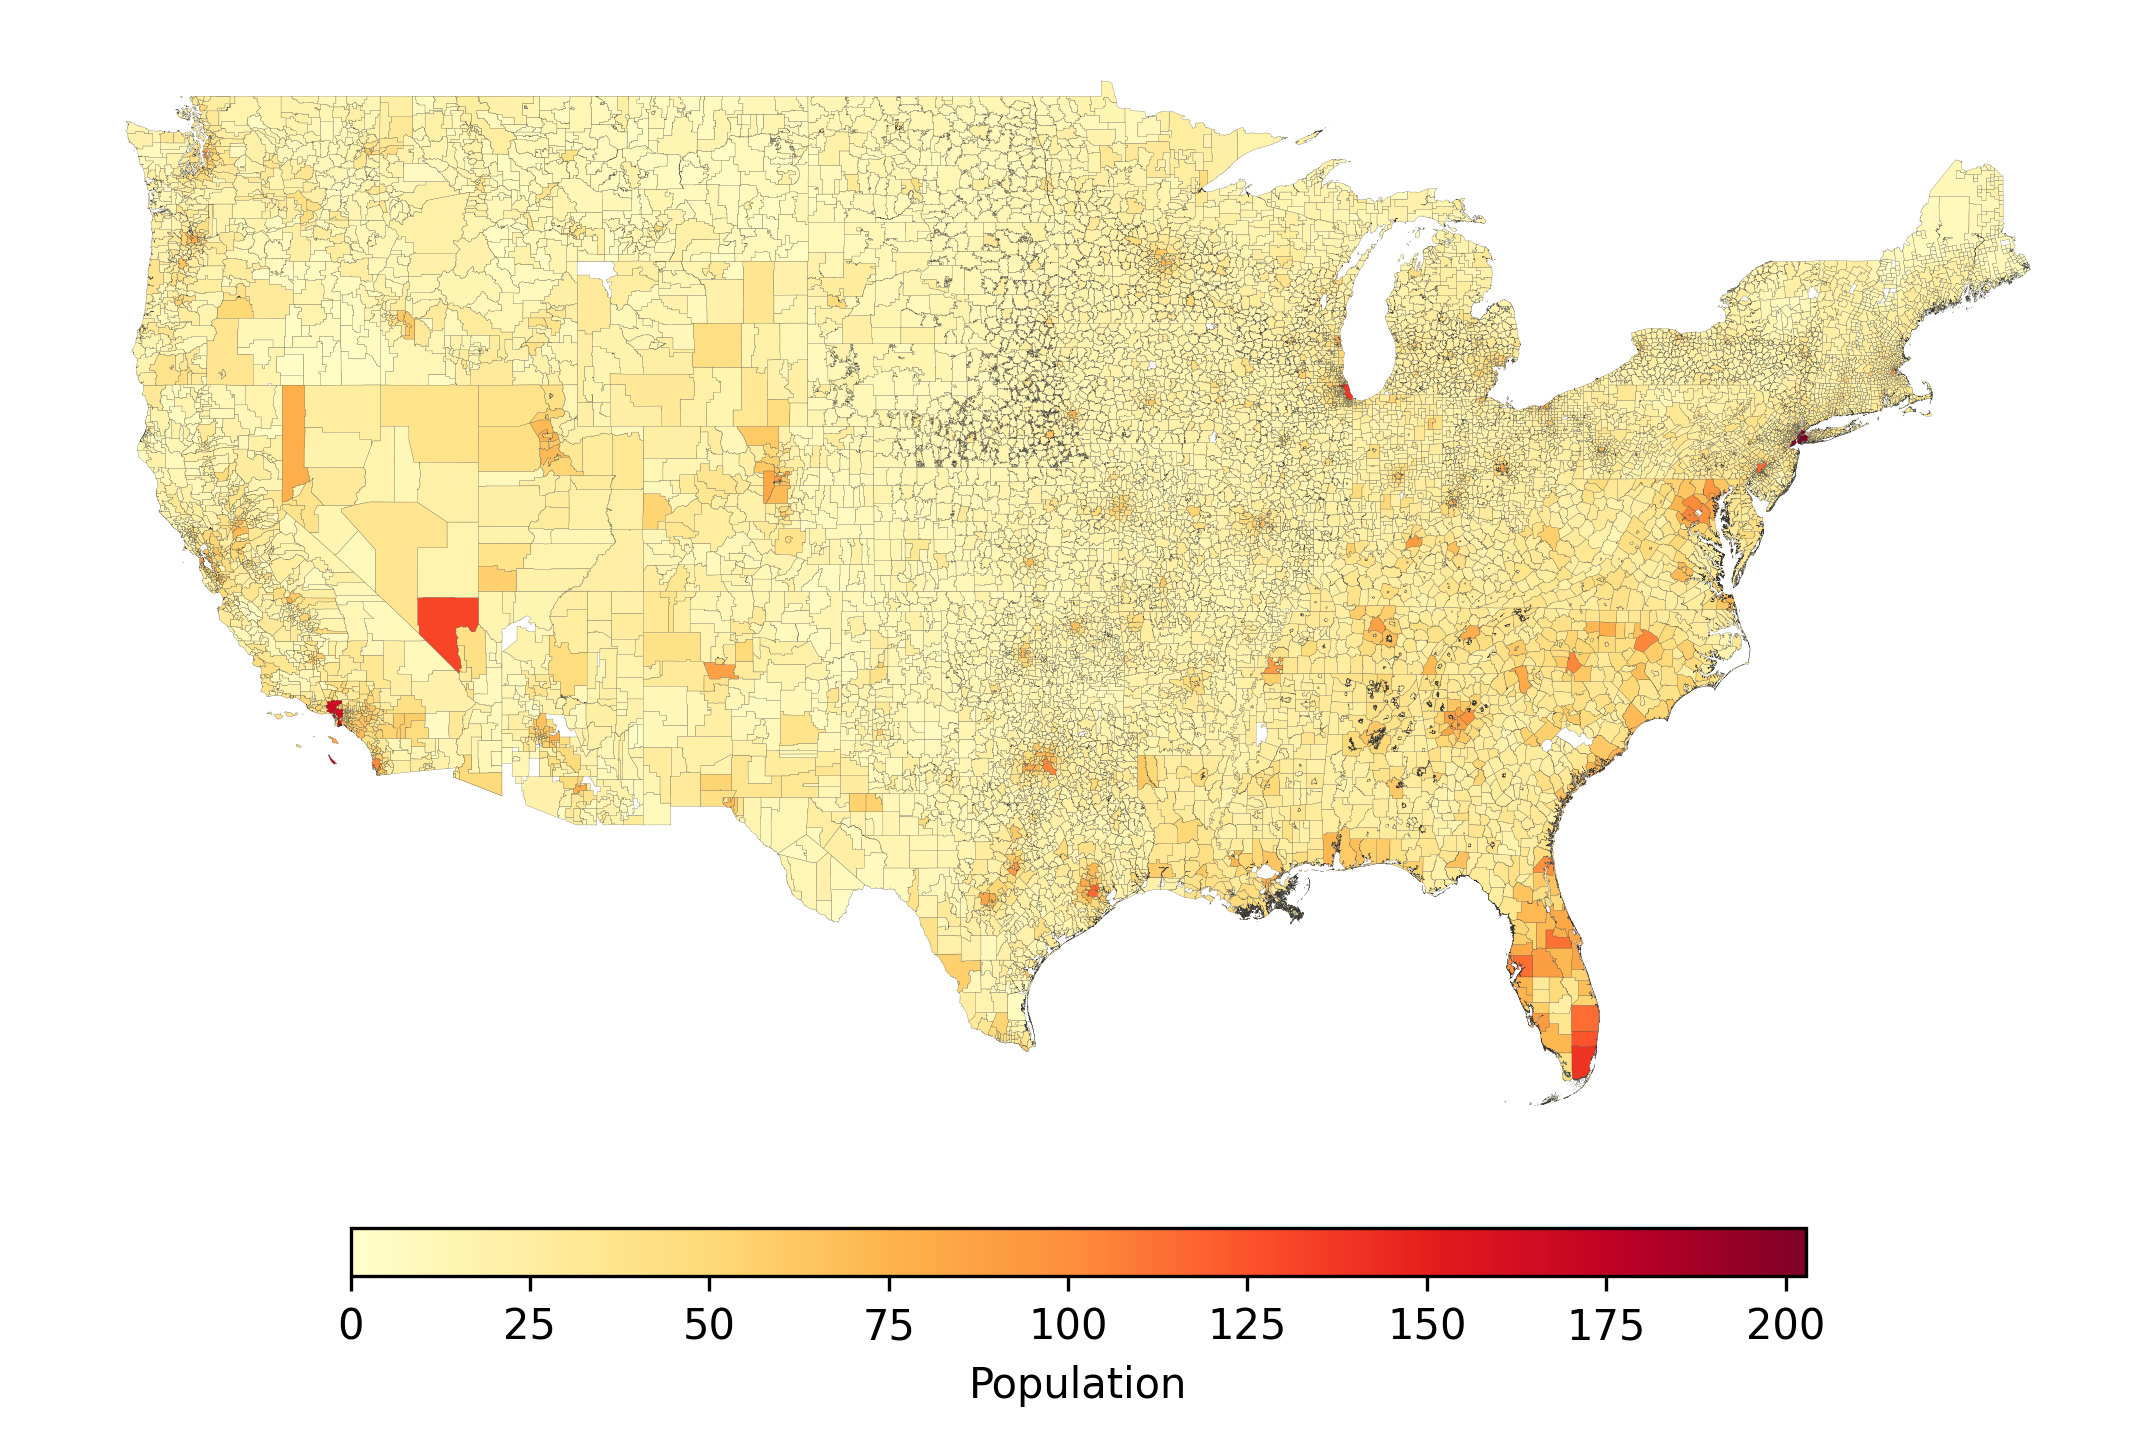

In [52]:
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    "Population",
    vcenter=None,
    y="true_pop_total",
    theme="YlOrRd"
)

In [12]:
joined_acs = joined.join(acs['White (RACE) - pct'], how="inner")
joined_acs["prop_nonwhite"] = 1 - acs['White (RACE) - pct'] / 100
joined_acs.prop_nonwhite.describe()
for state in [
#     (26, "Michigan"),
#     (37, "North Carolina"),
    # (72, "Puerto Rico"),
    (42, "Pennsylvania")
]:
    # heatmap(joined_acs.loc[state[0]], "Prop. non-white-only", y="prop_nonwhite", transform=None, vcenter=None, theme="Blues")
    # heatmap(joined.loc[state[0]], "% switched eligibility for any grant", y="switched_eligibility", transform=None, vcenter=None, theme="Oranges")
    heatmap(
        joined.loc[state[0]], 
        "% became ineligible for any grant", 
        file="ineligible.png",
        y="became_ineligible", 
        transform=None, 
        vcenter=None, 
        theme="Oranges",
        min=0,
        max=1
    )
    heatmap(
        joined.loc[state[0]], 
        "% became ineligible for any grant", 
        file="ineligible_dp.png",
        y="became_ineligible_dp", 
        transform=None, 
        vcenter=None, 
        theme="Oranges",
        min=0,
        max=1
    )
    heatmap(
        joined.loc[state[0]], 
        "% became eligible for any grant", 
        file="eligible.png",
        y="became_eligible", transform=None, vcenter=None, theme="Greens",
        min=0,
        max=1
    )
    heatmap(
        joined.loc[state[0]], 
        "% became eligible for any grant", 
        file="eligible_dp.png",
        y="became_eligible_dp", transform=None, vcenter=None, theme="Greens",
        min=0,
        max=1
    )
    # heatmap(joined.loc[state[0]], f"Misallocation per child in {state[1]} (cube root)")
    # heatmap(joined.loc[state[0]], f"Misallocation per eligible child in {state[1]} (cube root)", y="error_per_child_eligible")
    # heatmap(joined.loc[state[0]], "Log eligible children", y="true_children_eligible", transform='log', vcenter=None, theme="Purples")
    # heatmap(joined.loc[state[0]], "% eligible children", y="percent_eligible", transform=None, vcenter=None, theme="Purples")
    # heatmap(joined.loc[state[0]], "Log population", y="true_pop_total", transform='log', vcenter=None, theme="Greens")
    # heatmap(joined.loc[state[0]], "Log status quo entitlement", y="true_grant_total", transform='log', vcenter=None, theme="Greens")

### Random forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

averaged = results.groupby(["State FIPS Code", "District ID"]).mean().join(acs[variables], how="inner")
averaged["misalloc"] = averaged.est_grant_total - averaged.true_grant_total
averaged = averaged.replace('-', np.nan).replace('250,000+', '250000').dropna()
averaged = averaged.fillna(averaged.mean(skipna=True))

In [25]:
from sklearn.tree import plot_tree, DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=4)
features = [
    'Total population (RACE) - est',
    'White (RACE) - pct',
    'Black or African American (RACE) - pct',
#     'Cherokee tribal grouping (RACE) - pct',
#     'Chippewa tribal grouping (RACE) - pct',
#     'Navajo tribal grouping (RACE) - pct',
#     'Sioux tribal grouping (RACE) - pct',
    'Asian (RACE) - pct',
#     'Asian Indian (RACE) - pct',
#     'Chinese (RACE) - pct',
#     'Filipino (RACE) - pct',
#     'Japanese (RACE) - pct',
#     'Korean (RACE) - pct',
#     'Vietnamese (RACE) - pct',
#     'Other Asian (RACE) - pct',
#     'Native Hawaiian (RACE) - pct',
#     'Guamanian or Chamorro (RACE) - pct',
#     'Samoan (RACE) - pct',
#     'Some other race (RACE) - pct',
    'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est',
    'Foreign born (PLACE OF BIRTH) - pct',
    'Language other than English (LANGUAGE SPOKEN AT HOME) - pct',
    'Renter-occupied (HOUSING TENURE) - pct'
]
print(averaged[features].columns)
dt.fit(
    averaged[features],
    averaged.misalloc
)

Index(['Total population (RACE) - est', 'White (RACE) - pct',
       'Black or African American (RACE) - pct', 'Asian (RACE) - pct',
       'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est',
       'Foreign born (PLACE OF BIRTH) - pct',
       'Language other than English (LANGUAGE SPOKEN AT HOME) - pct',
       'Renter-occupied (HOUSING TENURE) - pct'],
      dtype='object')


DecisionTreeRegressor(max_depth=4)

In [26]:
importances = dt.feature_importances_
print(dt.n_features_)
importances

8


array([9.60892670e-01, 2.06042894e-02, 0.00000000e+00, 1.82353866e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.67654128e-04])

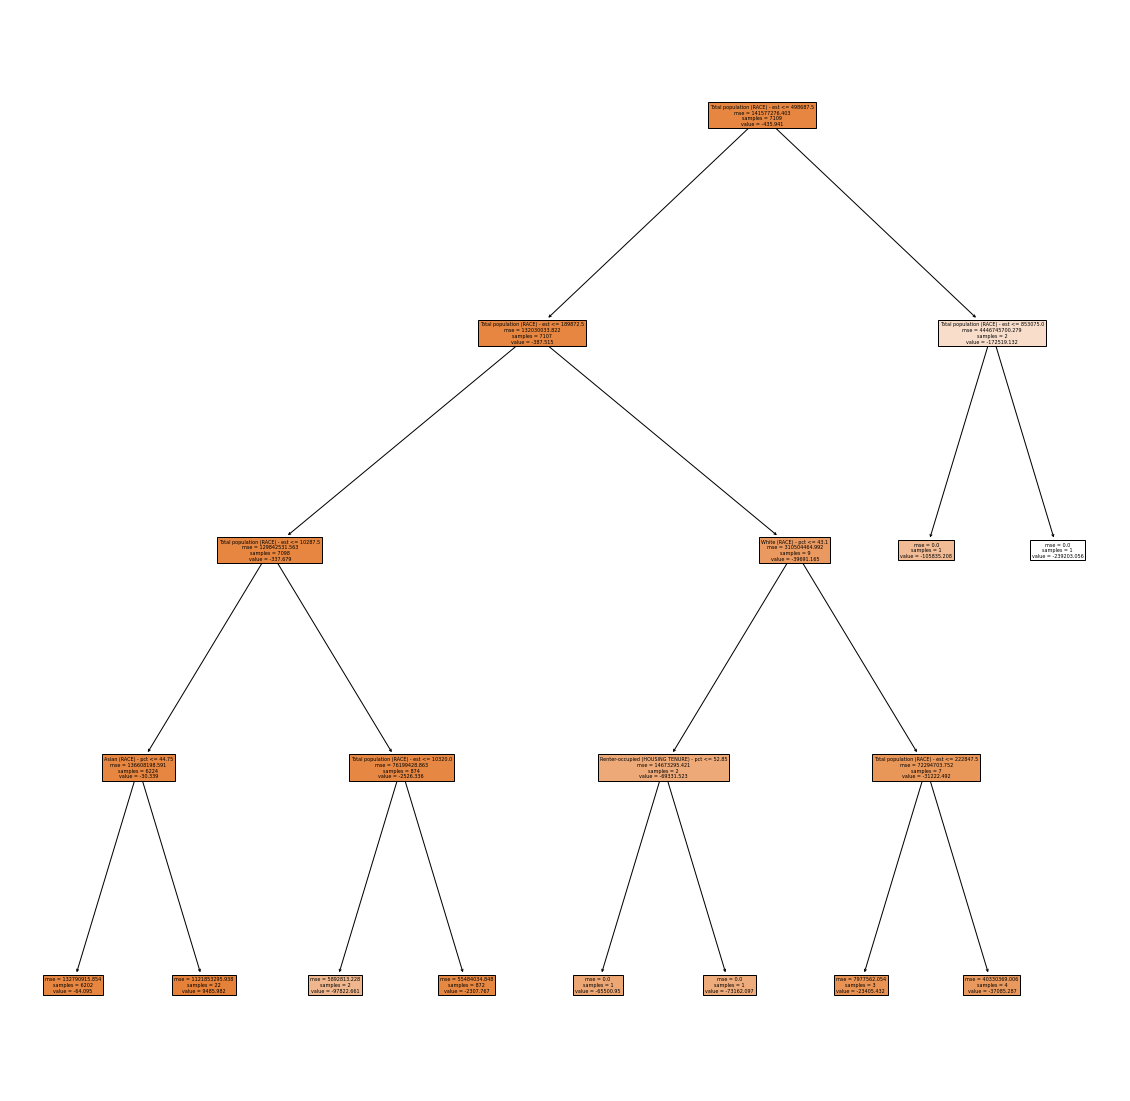

In [27]:
plt.rcParams['figure.figsize'] = [20, 20]
plot_tree(
    dt,
    feature_names = features,
    filled=True
)
plt.show()

### Plot for just (2.52, 0.0)-DP

In [18]:
grants = calc_total(funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting))
grants_gaus = calc_total(funding(saipe, SonnenbergAuthorizer, Gaussian(saipe, 2.52, 0.2), get_sppe("../data/sppe18.xlsx"), weighting))
error = grants.true_grant_total/sum(grants.true_grant_total) - grants.est_grant_total/sum(grants.est_grant_total)
error_gaus = grants_gaus.true_grant_total/sum(grants_gaus.true_grant_total) - grants_gaus.est_grant_total/sum(grants_gaus.est_grant_total)

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


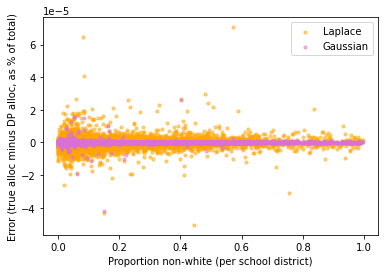

In [241]:
grants['prop_nonwhitealone'] = 1 - grants.race_2est / grants.race_1est
grants.prop_nonwhitealone[saipe.prop_nonwhitealone.isna()] = 0

plt.scatter(grants.prop_nonwhitealone, error, s=10, alpha=0.5, color='orange', label="Laplace")
plt.scatter(grants.prop_nonwhitealone, error_gaus, s=10, alpha=0.5, color='orchid', label="Gaussian")
ax = plt.gca()
ax.legend()
plt.xlabel("Proportion non-white (per school district)")
plt.ylabel("Error (true alloc minus DP alloc, as % of total)")
plt.show()